# Grand Theft Auto V Driving learning with Deep Learning (CNN and YOLO)
---
Self driving car in Grand Theft Auto V with Deep Learning and Object Detection. Adapted from
https://github.com/eritzyg/GTAV-Self-driving-car
by Iker Garcia and Eritz Yerga.



### Authors: Evan Miller, Allan Bourke, Joshua Gutowski, and Ian Kraft

See [this README](https://github.com/eritzyg/GTAV-Self-driving-car/blob/master/Notebook/README.md) for info about the notebook and required libraries.

---
## Index:

0. <a href="#0.-Object-Detection">Object Detection</a>
1. <a href="#1.-Generate-dataset">Generate dataset</a>
    * <a href="#Frame-capture-functions">Frame capture functions</a>
    * <a href="#Image-preprocessing-functions">Image preprocess functions</a>
    * <a href="#Game-control-and-input-reading-functions">Game control and input reading functions</a>
    * <b><a href="#Generate-dataset">Generate dataset</a></b>
2. <a href="#2.-Dataset-processing-utilities">Dataset processing utilities</a>
3. <a href="#3.-Define-the-model">Define our model</a>
4. <a href="#4.-Train">Train</a>
5. <a href="#5.-Run-our-model-in-the-game">Run our model in the game</a>

<a href=""></a>

---
First we import the libraries we are going to need to run this notebook.

In [1]:
importing = False

if importing:
    import sys
    sys.path.append(r'C:%APPDATA%\Python\Python38\Scripts')


    !pip install opencv-python
    !pip install tensorflow --ignore-installed --user

    !pip show tensorflow

In [2]:
import numpy as np
from PIL import ImageGrab
import cv2 
import time
from sys import stdout
from IPython.display import clear_output
import os
from grabber import Grabber
import threading
import matplotlib.pyplot as plt
from collections import Counter
from random import shuffle
import glob
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import TimeDistributed, LSTM, Flatten, Dense, InputLayer, MaxPooling2D, Dropout, Activation, Embedding, GRU, ConvLSTM2D, concatenate
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras import initializers
import h5py
import log
from heapq import nlargest

In [3]:
# Gets an array of filepaths to images from a folder

def loadImages(path):
    # Put files into lists and return them as one list of size 4
    image_files = sorted([os.path.join(path, 'train', file)
         for file in os.listdir(path + "/train") if      file.endswith('.png')])
 
    return image_files

# 0. Object Detection
By Evan Miller

This section utilizes the Yolov3 object detection model with pretrained weights for driving created by Lavanya Shukla on Kaggle. https://www.kaggle.com/lavanyashukla01/yolov3-lyft-dataset/?select=model.h5 

In [4]:
# Loads the model from the file
obj_model = load_model('yolo.h5', compile=False)

In [5]:
#By Lavanya Shukla on Kaggle.

#Custom class for functionality needed to extract bounding boxes from the YOLO model

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1):
    x = x - np.amax(x, axis, keepdims=True)
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4]   = _sigmoid(netout[..., 4])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i // grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[row, col, b, 4]
            
            if(objectness <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[row,col,b,:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[row,col,b,5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)

            boxes.append(box)

    return boxes

#TODO: Minimize implementation for images that don't need resizing
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
        

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()

In [6]:
#Takes a normalized rgb image file and returns a tuple of two image arrays. The first has the objects and the second has everything else.
#Adapted from Lavanya Shukla on Kaggle. Written by Evan Miller.

# VERSION 1: KEPT FOR DEBUGGING PURPOSES. DELETE WHEN FINISHED!


'''


def get_sub_images(imagepath):
    #get image size and model paramaters
    WIDTH, HEIGHT = 416,416
    anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
    class_threshold = 0.3
    
    #load original image
    image = load_img(filename)
    width, height = image.size
    IMAGE = img_to_array(image)
    
    # load the image with the required size
    image = load_img(filename, target_size=(WIDTH,HEIGHT))
    
    # convert to numpy array
    image = img_to_array(image)
    
    #normalize image and add a dimension
    image = image.astype('float32')
    image /= 255.0
    image = expand_dims(image, 0)
    
    yhat = obj_model.predict(image)
    
    # Create boxes
    boxes = list()
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, HEIGHT, WIDTH)
    
    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, HEIGHT, WIDTH, HEIGHT, WIDTH)
    
    # suppress non-maximal boxes
    do_nms(boxes, 0.5)
    
    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    
    objects = np.zeros_like(IMAGE)
    background = IMAGE[:]
    
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # Loop over area of each box
        for i in range(x1,x2):
            for j in range(y1,y2):
                # Data is channels last, so we copy and erase whole channels here
                # objects contains all values within the box
                objects[j][i] = IMAGE[j][i][:]
                # background gets this coordinate erased and is left with the remainder of the image
                background[j][i] = np.zeros_like(IMAGE[j][i])
    
    return (objects, background)
    
    
'''

"\n\n\ndef get_sub_images(imagepath):\n    #get image size and model paramaters\n    WIDTH, HEIGHT = 416,416\n    anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]\n    class_threshold = 0.3\n    \n    #load original image\n    image = load_img(filename)\n    width, height = image.size\n    IMAGE = img_to_array(image)\n    \n    # load the image with the required size\n    image = load_img(filename, target_size=(WIDTH,HEIGHT))\n    \n    # convert to numpy array\n    image = img_to_array(image)\n    \n    #normalize image and add a dimension\n    image = image.astype('float32')\n    image /= 255.0\n    image = expand_dims(image, 0)\n    \n    yhat = obj_model.predict(image)\n    \n    # Create boxes\n    boxes = list()\n    for i in range(len(yhat)):\n        # decode the output of the network\n        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, HEIGHT, WIDTH)\n    \n    # correct the sizes of the bounding boxes for the shape of t

In [7]:
#Takes a normalized rgb image and returns a tuple of two image arrays. The first has the objects and the second has everything else.
#Adapted from Lavanya Shukla on Kaggle. Written by Evan Miller.

def get_sub_images(IMAGE):
    #declare labels for the model
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat"]
    
    #get image size and model paramaters
    WIDTH, HEIGHT = 416,416
    anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
    class_threshold = 0.3
    
    #normalize image and add a dimension
    IMAGE = IMAGE.astype('float32')
    IMAGE /= 255.0
    inpt = np.expand_dims(IMAGE, 0)
    
    yhat = obj_model.predict(inpt)
    
    # Create boxes
    boxes = list()
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, HEIGHT, WIDTH)
    
    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, HEIGHT, WIDTH, HEIGHT, WIDTH)
    
    # suppress non-maximal boxes
    do_nms(boxes, 0.5)
    
    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    
    objects = np.zeros_like(IMAGE)
    background = IMAGE[:]
    
    for x in range(len(v_boxes)):
        box = v_boxes[x]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # Loop over area of each box
        for i in range(x1,x2):
            if i >= 416:
                continue
            for j in range(y1,y2):
                if j >= 416:
                    continue
                # Data is channels last, so we copy and erase whole channels here
                # objects contains all values within the box
                objects[j][i] = IMAGE[j][i][:]
                # background gets this coordinate erased and is left with the remainder of the image
                background[j][i] = np.zeros_like(IMAGE[j][i])
    
    return (objects, background)

# 1. Generate dataset

We will generate the dataset for training the model later on, it is important that we set the game on the first person view and take into account certain conditions for the dataset. Check the "Generation of the dataset" section in the [documentation](https://github.com/eritzyg/GTAV-Self-driving-car#documentation) for more information on this.

In [8]:
from game_control import PressKey, ReleaseKey
from getkeys import key_check

### Frame capture functions
These functions capture the game's frames in 1600x900 Windowed mode.

Screen record is the method to get one frame and img_thread is the thread we will later use to constantly capture the game's output.

In [9]:
global grb
grb = Grabber(bbox=(129,26,1152,1025))
def screen_record(method = 'ImageGrab'):
    if method == 'ImageGrab':
        printscreen =  ImageGrab.grab(bbox=(126,26,1152,1025))
        generalIMG = np.array(printscreen)
    
    elif method == 'grabber':
        global grb
        printscreen = None
        printscreen = grb.grab(printscreen)
        generalIMG = np.array(printscreen)
    
    return generalIMG          

In [10]:
global front_buffer
global back_buffer
front_buffer = np.zeros((1024, 1024), dtype=np.int8)
back_buffer = np.zeros((1024, 1024), dtype=np.int8)

global fps
fps = 0

def img_thread():
    global front_buffer
    global back_buffer
    global fps
    
    last_time = time.time()
    while True:
        front_buffer = screen_record()
        # Swap buffers
        front_buffer, back_buffer = back_buffer, front_buffer
        fps = int(1.0/(time.time()-last_time))
        last_time = time.time()
        
        if 'J' in key_check():
            break
    return
    

### Image preprocessing functions

We will define a function that will apply the preprocessing we want to the images:

In [11]:
# Code inspired by https://towardsdatascience.com/image-pre-processing-c1aec0be3edf
# Ideas written by Prince Canuma

#adds Gaussian blur to an image

def blur(res_img):

    no_noise = []
    for i in range(len(res_img)):
        blur = cv2.GaussianBlur(res_img[i], (5, 5), 0)
        no_noise.append(blur)

    return no_noise

In [12]:
def preprocess_image(image):
    proccessed_image = cv2.resize(image,(416,416))
    #proccessed_image = blur(proccessed_image)
    
    return proccessed_image

### Game control and input reading functions

These functions will read the inputs and generate a array for later use when generating the dataset:

In [13]:
def keys_to_output(keys):
    '''
    Convert keys to a ...multi-hot... array

    [A,W,D] boolean values.
    '''
    output = [0,0,0,0]
    
    if 'A' in keys:
        output[0] = 1
    if 'D' in keys:
        output[1] = 1
    if 'W' in keys:
        output[2] = 1
    if 'S' in keys:
        output[3] = 1
    
    return output

This sequencer thread will capture the sequences of 5 frames with a separation of 1/capturerate ms each.

In [14]:
global seq
global num
num = 0
seq = []

global key_out
key_out = [0, 0, 0, 0]

def image_sequencer_thread():
    global back_buffer
    global seq
    global key_out
    global num
    
    # Frames per second capture rate
    capturerate = 10.0
    while True:
        last_time = time.time()
        if len(seq) == 5:
            del seq[0]

        seq.append(preprocess_image(np.copy(back_buffer)))
        num = num + 1
        keys = key_check()
        if 'J' in keys:
            break
        key_out = keys_to_output(keys)
        waittime = (1.0/capturerate)-(time.time()-last_time)
        if waittime>0.0:
            time.sleep(waittime)

This function will be useful to check which class corresponds the input we captured to:

In [15]:
def counter_keys(key):
        if np.array_equal(key , [0,0,0,0]):
            return 0
        elif np.array_equal(key , [1,0,0,0]):
            return 1
        elif np.array_equal(key , [0,1,0,0]):
            return 2
        elif np.array_equal(key , [0,0,1,0]):
            return 3
        elif np.array_equal(key , [0,0,0,1]):
            return 4
        elif np.array_equal(key , [1,0,1,0]):
            return 5
        elif np.array_equal(key , [1,0,0,1]):
            return 6
        elif np.array_equal(key , [0,1,1,0]):
            return 7
        elif np.array_equal(key , [0,1,0,1]):
            return 8
        else:
            return -1

This is the function that the data saving threads will run to save the dataset to compressed files (change the path if needed):

In [16]:
def save_data(data,number):
    file_name = 'Data\\training_data'+str(number)+'.npz'
    np.savez_compressed(file_name,data=list([x[:5] for x in data]),labels=list([x[5:] for x in data]))
    del data

## Generate dataset

We will run this function to generate the dataset:

In [17]:
def run():
    global fps
    global front_buffer
    global back_buffer
    global seq
    global key_out
    global num
    training_data = []
    threads = list()
    th_img = threading.Thread(target=img_thread)
    th_seq = threading.Thread(target=image_sequencer_thread)
    threads.append(th_img)
    threads.append(th_seq)
    th_img.start()
    time.sleep(1)
    th_seq.start()
    l = 0
    fn = 0
    time.sleep(4)
    last_num = 0
    
    number_of_keys = [0,0,0,0,0,0,0,0,0]
    
    while True:
        img_seq = seq.copy()
        output = key_out.copy()
        
        while len(img_seq) != 5 or last_num==num:
            del img_seq, output
            img_seq = seq.copy()
            output = key_out.copy()
        last_num = num
        
        clear_output(wait=True)
        stdout.write('Recording at {} FPS \n'.format(fps))
        stdout.write('Images in sequence {} \n'.format(len(img_seq)))
        stdout.write('Training data len {} secuences \n'.format(l))
        stdout.write('Number of archives {}\n'.format(fn))
        stdout.write('Keys pressed: ' + str(output) + ' \n')
        stdout.write('Keys samples in this file: ' + 'none:' + str(number_of_keys[0]) + ' A:' + str(number_of_keys[1])+ ' D:' + str(number_of_keys[2]) + ' W:' + str(number_of_keys[3])+ ' S:' + str(number_of_keys[4]) + ' AW:'  + str(number_of_keys[5]) + ' AS:' + str(number_of_keys[6]) + ' WD:' + str(number_of_keys[7]) + ' SD:' + str(number_of_keys[8]) + ' \n')
        stdout.flush()
        
        key  = counter_keys(output)
        
        if key != -1:
            larg = nlargest(9,number_of_keys)
            prop = (9. - float(larg.index(number_of_keys[key])))/10
            if(number_of_keys[key]  > np.mean(number_of_keys) * 1.25):
                prop = prop + 0.05
            if (np.random.rand() > prop):
                number_of_keys[key] += 1
                l = l+1
                training_data.append([img_seq[0],img_seq[1],img_seq[2],img_seq[3],img_seq[4], output])
            
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break

        #if len(training_data) % 500 == 0 and len(training_data) != 0:
        if len(training_data) % 20 == 0 and len(training_data) != 0:
            threading.Thread(target=save_data, args=(training_data.copy(), fn,)).start()
            fn = fn + 1
            del training_data
            training_data = []
            
        if 'J' in key_check():
            threading.Thread(target=save_data, args=(training_data.copy(), fn,)).start()
            fn = fn + 1
            del training_data
            training_data = []
            break
            


Now we will run the capture and generation of the dataset, remember that the game's window must be in 1280x1024 resolution and located in the top left part of the screen ((0,0) coordinates).

Once you captured all the data you need you can press 'J' to stop the run function and archive the current sequences.

In [18]:
capturing = False

if capturing:
    time.sleep(5)
    run()

In [19]:
'''
Plots images from the data file
'''

plotImgs = False
if plotImgs:
    with np.load('Data\\training_data4.npz') as data:
        training_data = data['data']
    
    i= 10
    for j in range(5):
        plt.imshow(cv2.cvtColor(training_data[i][j], cv2.COLOR_BGR2RGB))
        plt.show()
        plt.imshow(cv2.cvtColor(training_data[i][j], cv2.COLOR_BGR2RGB))
        plt.show()
        print('---------------------------------------------------------')

In [20]:
'''
Plots images from the data file after object detection and separation
'''

plotImgs = False
if plotImgs:
    with np.load('Data\\training_data4.npz') as data:
        training_data = data['data']
    
    for i in range(len(training_data)):
        train_objects = []
        train_background = []
        for j in range(5):
            temp1,temp2 = get_sub_images(training_data[i][j])
            train_objects.append(temp1)
            train_background.append(temp2)

        for j in range(5):
            plt.imshow(cv2.cvtColor(train_objects[j], cv2.COLOR_BGR2RGB))
            plt.show()
            plt.imshow(cv2.cvtColor(train_background[j], cv2.COLOR_BGR2RGB))
            plt.show()
            print('---------------------------------------------------------')

This function is used to count the number of instances per class in a set:

In [56]:
#TODO: Rewrite function to use one bit hot encoded values

def number_instances_per_class(data):
    
    nonekey = []
    A = []
    D = []
    W = []
    S = []
    
    AD = []
    AW = []
    AS = []
    DW =[]
    DS = []
    WS =[]
    
    ADW = []
    AWS =[]
    ADS = []
    DWS = []
    
    ASWS = []
    
    data = [x[0] for x in data]
    
    np.random.shuffle(data)
    
    for d in data:
        if np.array_equal(d, [0,0,0,0]):
            nonekey.append(d)
        elif np.array_equal(d, [1,0,0,0]):
            A.append(d)
        elif np.array_equal(d, [0,1,0,0]):
            D.append(d)
        elif np.array_equal(d , [0,0,1,0]):
            W.append(d)
        elif np.array_equal(d , [0,0,0,1]):
            S.append(d)
        elif np.array_equal(d , [1,1,0,0]):
            AD.append(d)
        elif np.array_equal(d , [1,0,1,0]):
            AW.append(d)
        elif np.array_equal(d , [1,0,0,1]):
            AS.append(d)
        elif np.array_equal(d , [0,1,1,0]):
            DW.append(d)
        elif np.array_equal(d , [0,1,0,1]):
            DS.append(d)
        elif np.array_equal(d , [0,0,1,1]):
            WS.append(d)
        elif np.array_equal(d , [1,1,1,0]):
            ADW.append(d)
        elif np.array_equal(d , [1,1,0,1]):
            AWS.append(d)
        elif np.array_equal(d , [1,1,0,1]):
            ADS.append(d)
        elif np.array_equal(d , [0,1,1,1]):
            DWS.append(d)
        elif np.array_equal(d , [1,1,1,1]):
            ASWS.append(d)
    return [nonekey,A,D,W,S,AW,AS,DW,DS]
    


This function will balance the number of instances of the classes in a set by deleting extra instances after shuffling:

In [57]:
def balance_data(data_in_clases):
    balanced_data = []
    data_in_clases.sort(key=len)
    max_len = len(data_in_clases[0])
        
    for data in data_in_clases:
        if len(data) > max_len:
            data=data[:max_len]
        for d in data:
            balanced_data.append(d)
        
    np.random.shuffle(balanced_data)
    
    return balanced_data
    

For debug purposes:

In [58]:
debug = False
if debug:
    with np.load('Data\\training_data4.npz') as data:
        images = data['data']
        labels = data['labels']

    number = number_instances_per_class(labels)
    print('none: ' + str(len(number[0])))
    print('A: ' + str(len(number[1])))
    print('D ' + str(len(number[2])))
    print('W ' + str(len(number[3])))
    print('S ' + str(len(number[4])))
    print('AW ' + str(len(number[5])))
    print('AS ' + str(len(number[6])))
    print('DW ' + str(len(number[7])))
    print('DS ' + str(len(number[8])))

    #TODO: re-implement data balancing
    balanced_data = balance_data(number)
    number = number_instances_per_class(balanced_data)
    print('none: ' + str(len(number[0])))
    print('A: ' + str(len(number[1])))
    print('D ' + str(len(number[2])))
    print('W ' + str(len(number[3])))
    print('S ' + str(len(number[4])))
    print('AW ' + str(len(number[5])))
    print('AS ' + str(len(number[6])))
    print('DW ' + str(len(number[7])))
    print('DS ' + str(len(number[8])))


[[[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 0 0]]

 [[0 1 1 0]]

 [[0 1 1 0]]

 [[1 0 1 0]]

 [[0 1 1 0]]

 [[0 0 1 0]]

 [[0 0 1 0]]

 [[1 0 1 0]]

 [[1 0 1 0]]

 [[0 0 1 0]]

 [[0 0 0 1]]

 [[0 0 0 1]]

 [[0 0 0 1]]]
none: 0
A: 0
D 8
W 3
S 3
AW 3
AS 0
DW 3
DS 0
[]
none: 0
A: 0
D 0
W 0
S 0
AW 0
AS 0
DW 0
DS 0


# 3. Define the model

We will define the model to use in our training, please select the model you want to use in the cell bellow (the models are described in the "Definition of the DNN" of the [documentation](https://github.com/eritzyg/GTAV-Self-driving-car#documentation)):

In [24]:
# Select the model to use:
# 'CNN+MPL' : Convolutional neural network with multi layer perceptron.
# 'CNN+RNN' : Convolutional neural network with recurrent neural network.
# 'YOLO'    : Processes the objects and the background seperately 
selected_model = 'YOLO'

And now we define the corresponding model:

In [25]:
if selected_model == 'CNN+RNN':
    model = Sequential()

    model.add(InputLayer(input_shape=(5, 270, 480, 3)))

    model.add(TimeDistributed(Convolution2D(32, (4,4), data_format='channels_last')))
    model.add(TimeDistributed(Activation('relu')))
    print(model.output_shape)

    model.add(TimeDistributed(Convolution2D(32, (4,4), data_format='channels_last')))
    model.add(TimeDistributed(Activation('relu')))
    print(model.output_shape)

    model.add(TimeDistributed(MaxPooling2D(pool_size=(5, 5), data_format='channels_last')))
    model.add(TimeDistributed(Dropout(0.25)))
    print(model.output_shape)

    model.add(TimeDistributed(Convolution2D(16, (3,3), data_format='channels_last')))
    model.add(TimeDistributed(Activation('relu')))
    print(model.output_shape)


    model.add(TimeDistributed(MaxPooling2D(pool_size=(5, 5), data_format='channels_last')))
    model.add(TimeDistributed(Dropout(0.25)))
    print(model.output_shape)

    model.add(TimeDistributed(Flatten()))
    print(model.output_shape)

    model.add(GRU(256, kernel_initializer=initializers.RandomNormal(stddev=0.001))) #128
    model.add(Dropout(0.25))
    print(model.output_shape)

    model.add(Dense(100))
    print(model.output_shape)

    model.add(Dense(80))
    print(model.output_shape)

    model.add(Dense(40))
    print(model.output_shape)

    model.add(Dense(9, activation='sigmoid'))
    print(model.output_shape)

    opt = optimizers.RMSprop(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy']) 

In [26]:
if selected_model == 'CNN+MLP':
    model = Sequential()

    model.add(InputLayer(input_shape=(5, 270, 480, 3)))

    model.add(TimeDistributed(Convolution2D(16, (4,8), data_format='channels_last')))
    model.add(TimeDistributed(Activation('relu')))
    print(model.output_shape)

    model.add(TimeDistributed(Convolution2D(16, (4,4), data_format='channels_last')))
    model.add(TimeDistributed(Activation('relu')))
    print(model.output_shape)

    model.add(TimeDistributed(MaxPooling2D(pool_size=(5, 5), data_format='channels_last')))
    model.add(TimeDistributed(Dropout(0.25)))
    print(model.output_shape)

    model.add(TimeDistributed(Convolution2D(12, (3,3), data_format='channels_last')))
    model.add(TimeDistributed(Activation('relu')))
    print(model.output_shape)

    model.add(TimeDistributed(MaxPooling2D(pool_size=(5, 5), data_format='channels_last')))
    model.add(TimeDistributed(Dropout(0.25)))
    print(model.output_shape)

    model.add(Flatten())
    print(model.output_shape)

    model.add(Dense(300))
    print(model.output_shape)
    model.add(Dense(100))
    print(model.output_shape)
    print(model.output_shape)
    model.add(Dense(9, activation='sigmoid'))
    print(model.output_shape)

    opt = optimizers.rmsprop(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy']) 

In [27]:
# Model by Evan Miller
#
# Takes in two inputs corresponding to the images after they have been split into objects and background
# by the YOLO object detection algorithm. These images are processed with a CNN and an RNN+CNN respectively, then they are
# concatenated and fed through some Dense layers for a final prediction.

if selected_model == 'YOLO':
    input1 = tf.keras.Input(shape=(5, 416, 416, 3))
    x1 = TimeDistributed(Convolution2D(16, (4,8), data_format='channels_last'))(input1)
    x1 = TimeDistributed(Activation('relu'))(x1)
    x1 = TimeDistributed(Convolution2D(16, (4,4), data_format='channels_last'))(x1)
    x1 = TimeDistributed(Activation('relu'))(x1)
    x1 = TimeDistributed(MaxPooling2D(pool_size=(5, 5), data_format='channels_last'))(x1)
    x1 = TimeDistributed(Dropout(0.25))(x1)
    x1 = TimeDistributed(Convolution2D(12, (3,3), data_format='channels_last'))(x1)
    x1 = TimeDistributed(Activation('relu'))(x1)
    x1 = TimeDistributed(MaxPooling2D(pool_size=(5, 5), data_format='channels_last'))(x1)
    x1 = TimeDistributed(Dropout(0.25))(x1)
    x1 = Flatten()(x1)
    x1 = Dense(300)(x1)
    x1 = Dense(100)(x1)
    #x1 = Dense(9, activation='sigmoid')(x1)
    x1 = Model(inputs=input1,outputs=x1)
    
    input2 = tf.keras.Input(shape=(5, 416, 416, 3))
    x2 = TimeDistributed(Convolution2D(32, (4,4), data_format='channels_last'))(input2)
    x2 = TimeDistributed(Activation('relu'))(x2)
    x2 = TimeDistributed(Convolution2D(32, (4,4), data_format='channels_last'))(x2)
    x2 = TimeDistributed(Activation('relu'))(x2)
    x2 = TimeDistributed(MaxPooling2D(pool_size=(5, 5), data_format='channels_last'))(x2)
    x2 = TimeDistributed(Dropout(0.25))(x2)
    x2 = TimeDistributed(Convolution2D(16, (3,3), data_format='channels_last'))(x2)
    x2 = TimeDistributed(Activation('relu'))(x2)
    x2 = TimeDistributed(MaxPooling2D(pool_size=(5, 5), data_format='channels_last'))(x2)
    x2 = TimeDistributed(Dropout(0.25))(x2)
    x2 = TimeDistributed(Flatten())(x2)
    x2 = GRU(256, kernel_initializer=initializers.RandomNormal(stddev=0.001))(x2)
    x2 = Dropout(0.25)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(100)(x2)
    #x2 = Dense(80)(x2)
    #x2 = Dense(40)(x2)
    #x2 = Dense(9, activation='sigmoid')(x2)
    x2 = Model(inputs=input2,outputs=x2)
    
    combined = concatenate([x1.output,x2.output])
    out = Dense(80)(combined)
    out = Dense(40)(out)
    out = Dense(9, activation='softmax')(out)
    
    model = Model(inputs=[x1.input,x2.input], outputs=out)

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5, 416, 416, 0                                            
__________________________________________________________________________________________________
time_distributed_10 (TimeDistri (None, 5, 413, 413,  1568        input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5, 416, 416, 0                                            
__________________________________________________________________________________________________
time_distributed_11 (TimeDistri (None, 5, 413, 413,  0           time_distributed_10[0][0]        
____________________________________________________________________________________________

# 4. Train

Now we will define some functions to reshape the data according to the input of our model:

In [29]:
#Determine value range for images from the game. 

def reshape_custom_X(data, verbose = 0):
    reshaped = np.zeros((data.shape[0], 5, 416, 416, 3), dtype=np.float32)
    for i in range(0, data.shape[0]):
        for j in range(0, 5):
            if (verbose == 1):
                clear_output(wait=True)
                stdout.write('Reshaped image: ' + str(i))
                stdout.flush()
            reshaped[i][j] = data[i][j]/255.
            
    return reshaped

def reshape_custom_y(data):
    reshaped = np.zeros((data.shape[0], 9), dtype=np.float32)
    for i in range(0, data.shape[0]):
        if np.array_equal(data[i] , [0,0,0,0]):
            reshaped[i][0] = 1.
        elif np.array_equal(data[i] , [1,0,0,0]):
            reshaped[i][1] = 1.
        elif np.array_equal(data[i] , [0,1,0,0]):
            reshaped[i][2] = 1.
        elif np.array_equal(data[i] , [0,0,1,0]):
            reshaped[i][3] = 1.
        elif np.array_equal(data[i] , [0,0,0,1]):
            reshaped[i][4] = 1.
        elif np.array_equal(data[i] , [1,0,1,0]):
            reshaped[i][5] = 1.
        elif np.array_equal(data[i] , [1,0,0,1]):
            reshaped[i][6] = 1.
        elif np.array_equal(data[i] , [0,1,1,0]):
            reshaped[i][7] = 1.
        elif np.array_equal(data[i] , [0,1,0,1]):
            reshaped[i][8] = 1.
    return reshaped

These functions will help for picking the number of batches and the start and end indexes:

In [30]:
def get_num_batches(length, BATCH_SIZE):
    if (int(length/BATCH_SIZE)*BATCH_SIZE == length):
        return int(length/BATCH_SIZE)
    else:
        return int(length/BATCH_SIZE)+1

def get_start_end(iteration, BATCH_SIZE, max_length):
    start = iteration*BATCH_SIZE
    if (start > max_length):
        print("ERROR: Check iterations made! Must be wrong")
        return -1, -1
    end = (iteration+1)*BATCH_SIZE
    if (end > max_length):
        end = max_length
    return start, end

And now we run the training process, the accuracy can be seen after each epoch.

In [31]:
def tf_data_generator(file_list, batch_size = 1):
    i = 0
    while True:
        if i*batch_size >= len(file_list):
            print("\nShuffling and Restarting...")
            i = 0
            np.random.shuffle(file_list)
        else:
            file_chunk = file_list[i*batch_size:(i+1)*batch_size] 
            print("\nTraining Files: ", file_chunk)
            data = [[],[]]
            labels = []
            
            for fil in file_chunk:
                with np.load(fil) as dat:
                    training_data_images = dat['data']
                    training_data_labels = dat['labels']

                #number = number_instances_per_class(training_data)
                #training_data = np.array(balance_data(number))

                to_shuffle = list(zip(training_data_images, training_data_labels))
                np.random.shuffle(to_shuffle)
                training_data_images, training_data_labels = zip(*to_shuffle)

                train_objects = []
                train_background = []
                for k in range(len(training_data_images)):
                    train_objects.append([])
                    train_background.append([])
                    for j in range(5):
                        temp1,temp2 = get_sub_images(training_data_images[k][j])
                        train_objects[k].append(temp1)
                        train_background[k].append(temp2)

                X_train = [reshape_custom_X(np.array(train_objects)), reshape_custom_X(np.array(train_background))]
                y_train = reshape_custom_y(np.array(training_data_labels))
                
                for x in range(X_train[0].shape[0]):
                    data[0].append(X_train[0][x])
                    data[1].append(X_train[1][x])
                    labels.append(y_train[x])
                
                
            yield (np.array(data[0]), np.array(data[1])), labels
            i = i + 1

In [32]:
#Generator version of training function

#TODO: batch size greater than 2 crashes the kernel to crash. Also, certain files (Redei's, likely the large ones) cause the kernel to crash

training = False
epochs = 1
batch_size = 1

if training:
    file_names = glob.glob("Data\\**\*.npz", recursive=True)
    np.random.shuffle(file_names)
    train_file_names = file_names[0:int(len(file_names)*0.7)]
    validation_file_names = file_names[int(len(file_names)*0.7):]

    print(len(train_file_names), len(validation_file_names))
    print(train_file_names, validation_file_names)
    

    train_dataset = tf.data.Dataset.from_generator(tf_data_generator, args = [train_file_names, batch_size], 
                                                  output_shapes = (((None,5,416,416,3), (None,5,416,416,3)),(None,9)),
                                                  output_types = ((tf.float32, tf.float32), tf.float32))

    validation_dataset = tf.data.Dataset.from_generator(tf_data_generator, args = [validation_file_names, batch_size],
                                                  output_shapes = (((None,5,416,416,3), (None,5,416,416,3)),(None,9)),
                                                  output_types = ((tf.float32, tf.float32), tf.float32))


    steps_per_epoch = np.int(np.ceil(len(train_file_names)/batch_size))
    validation_steps = np.int(np.ceil(len(validation_file_names)/batch_size))
    print("steps_per_epoch = ", steps_per_epoch)
    print("validation_steps = ", validation_steps)

    model.fit(train_dataset, validation_data = validation_dataset, steps_per_epoch = steps_per_epoch,
             validation_steps = validation_steps, epochs = epochs)

34 15
['Data\\training_data26.npz', 'Data\\training_data33.npz', 'Data\\training_data20.npz', 'Data\\training_data21.npz', 'Data\\training_data8.npz', 'Data\\training_data23.npz', 'Data\\training_data11.npz', 'Data\\training_data35.npz', 'Data\\training_data12.npz', 'Data\\Miller Data\\Miller_training_data1.npz', 'Data\\training_data36.npz', 'Data\\training_data22.npz', 'Data\\training_data38.npz', 'Data\\training_data39.npz', 'Data\\training_data2.npz', 'Data\\training_data5.npz', 'Data\\training_data24.npz', 'Data\\training_data4.npz', 'Data\\training_data34.npz', 'Data\\training_data15.npz', 'Data\\training_data6.npz', 'Data\\training_data42.npz', 'Data\\training_data19.npz', 'Data\\training_data1.npz', 'Data\\training_data28.npz', 'Data\\training_data32.npz', 'Data\\training_data41.npz', 'Data\\Miller Data\\Miller_training_data3.npz', 'Data\\training_data18.npz', 'Data\\training_data14.npz', 'Data\\training_data3.npz', 'Data\\training_data10.npz', 'Data\\training_data43.npz', 'Data

In [33]:
#Old training implementation kept for archiving


'''

log.openlog()

# Define the sizes and epoches
BATCH_SIZE = 10
TEST_BATCH_SIZE = 10
n_epochs = 6

# This path will be the path used to load the dataset files!
files = glob.glob("Data\\*.npz")


actual_file = 0
acc_for_files = []
for fil in files:
    actual_file = actual_file + 1
    log.output("\n Loading input: "+fil)
    with np.load(fil) as data:
        training_data_images = data['data']
        training_data_labels = data['labels']

    #print("\n Balancing data...")
    #number = number_instances_per_class(training_data)
    #training_data = np.array(balance_data(number))
    
    log.output("\n Reshaping data...")
    
    to_shuffle = list(zip(training_data_images, training_data_labels))
    np.random.shuffle(to_shuffle)
    training_data_images, training_data_labels = zip(*to_shuffle)
    
    #np.random.shuffle(training_data)
    train_x = training_data_images[0:int(len(training_data_images)*0.90)]
    train_y = training_data_labels[0:int(len(training_data_labels)*0.90)]
    test_x = training_data_images[int(len(training_data_images)*0.90):]
    test_y = training_data_labels[int(len(training_data_labels)*0.90):]
    #test = training_data[int(len(training_data)*0.90):len(training_data)]
    del training_data_images, training_data_labels
    
    log.output("\n Executing Object Detection...")
    
    train_objects = []
    train_background = []
    for i in range(len(train_x)):
        train_objects.append([])
        train_background.append([])
        for j in range(5):
            temp1,temp2 = get_sub_images(train_x[i][j])
            train_objects[i].append(temp1)
            train_background[i].append(temp2)
    
    test_objects = []
    test_background = []
    for i in range(len(test_x)):
        test_objects.append([])
        test_background.append([])
        for j in range(5):
            temp1,temp2 = get_sub_images(test_x[i][j])
            test_objects[i].append(temp1)
            test_background[i].append(temp2)
    
    X_train = [reshape_custom_X(np.array(train_objects)), reshape_custom_X(np.array(train_background))]
    y_train = reshape_custom_y(np.array(train_y))
    X_test = [reshape_custom_X(np.array(test_objects)), reshape_custom_X(np.array(test_background))]
    y_test= reshape_custom_y(np.array(test_y))
    del train_x, train_y, test_x, test_y, test_objects, test_background, train_objects, train_background
    
    log.output("\n Training...")
    data_length = len(X_train[0])
    n_batch = get_num_batches(data_length, BATCH_SIZE)
    for epoch in range(n_epochs):
        for iteration in range(n_batch):
            start, end = get_start_end(iteration, BATCH_SIZE, data_length)
            model.fit(x=[X_train[0][start:end], X_train[1][start:end]], y=y_train[start:end], epochs=1, verbose=0)
            clear_output(wait=True)
            log.output('\n => File : ' + str(actual_file) + ' of ' + str(len(files)))
            log.output('\n ==> EPOCH : ' + str(epoch+1) + ' of ' + str(n_epochs))
            log.output('\n ===> Iteration: ' + str(iteration+1) + ' of ' + str(n_batch))
            score = model.evaluate((X_train[0][start:end], X_train[1][start:end]), y_train[start:end], verbose=0)
            log.output("\n Train batch accuracy: %.2f%%" % (score[1]*100))
            stdout.flush()
        prec = np.zeros((9))
        for i in range(len(y_test)):
            p = np.argmax(model.predict((X_test[0][i:i+1], X_test[1][i:i+1])), axis=1)
            prec[p] = prec[p] + 1
        log.output("\n ==> Predictions:"+str(prec))
        stdout.flush()   
    total_acc = 0.0
    num = 0
    data_length = len(X_test[0])
    n_batch = get_num_batches(data_length, TEST_BATCH_SIZE)
    for iteration in range(n_batch):
        start, end = get_start_end(iteration, TEST_BATCH_SIZE, data_length)
        score = model.evaluate((X_test[0][start:end], X_test[1][start:end]), y_test[start:end], verbose=0)
        log.output("\n => Batch %s: %.2f%%" % (model.metrics_names[1], score[1]*100))
        total_acc = total_acc + score[1]
        num = num + 1
    total_acc = total_acc/float(num)
    log.output("\n ==> Total acc for file %s: %.2f%%" % (fil, total_acc*100))
    acc_for_files.append(total_acc*100)


    prec = np.zeros((9))
    for i in range(len(y_test)):
        p = np.argmax(model.predict((X_test[0][i:i+1], X_test[1][i:i+1])), axis=1)
        prec[p] = prec[p] + 1
    log.output("\n ==> Predictions:"+str(prec))
    time.sleep(5)

for acc in range(len(acc_for_files)):
    log.output("\n ==> Total acc after file %d: %.2f%%" % (acc, acc_for_files[acc]))
    
    
log.closelog()

'''

'\n\nlog.openlog()\n\n# Define the sizes and epoches\nBATCH_SIZE = 10\nTEST_BATCH_SIZE = 10\nn_epochs = 6\n\n# This path will be the path used to load the dataset files!\nfiles = glob.glob("Data\\*.npz")\n\n\nactual_file = 0\nacc_for_files = []\nfor fil in files:\n    actual_file = actual_file + 1\n    log.output("\n Loading input: "+fil)\n    with np.load(fil) as data:\n        training_data_images = data[\'data\']\n        training_data_labels = data[\'labels\']\n\n    #print("\n Balancing data...")\n    #number = number_instances_per_class(training_data)\n    #training_data = np.array(balance_data(number))\n    \n    log.output("\n Reshaping data...")\n    \n    to_shuffle = list(zip(training_data_images, training_data_labels))\n    np.random.shuffle(to_shuffle)\n    training_data_images, training_data_labels = zip(*to_shuffle)\n    \n    #np.random.shuffle(training_data)\n    train_x = training_data_images[0:int(len(training_data_images)*0.90)]\n    train_y = training_data_labels[0

Now we save the learned network:

In [34]:
#TODO: model failing to save due to untraced functions

import h5py as h5py
model.save('Model\\'+selected_model)

INFO:tensorflow:Assets written to: Model\YOLO\assets


INFO:tensorflow:Assets written to: Model\YOLO\assets


YOLO


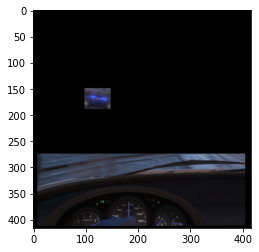

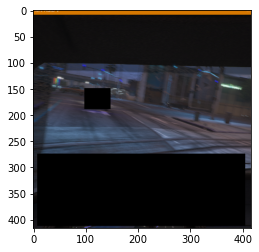

---------------------------------------------------------


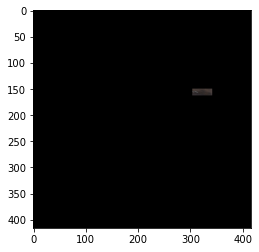

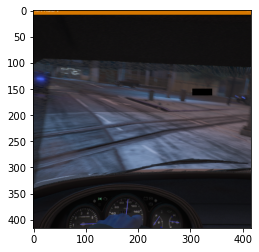

---------------------------------------------------------


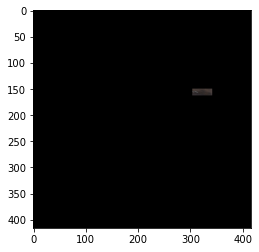

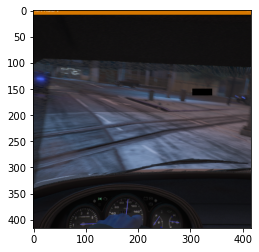

---------------------------------------------------------


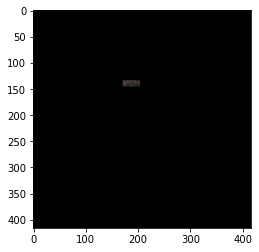

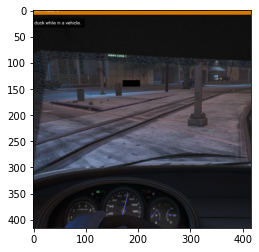

---------------------------------------------------------


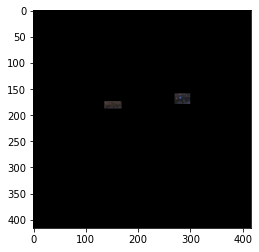

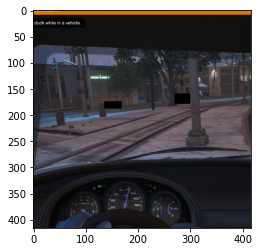

---------------------------------------------------------
[1]


In [35]:
'''
Plots images from the data file after object detection and separation, then executes and prints a prediction on the sequence
'''

print(selected_model)
#model = load_model('Data\\'+selected_model)

plotImgs = True
if plotImgs:
    with np.load('Data\\training_data1.npz') as data:
        training_data = data['data']
    
    i= 10
    
    train_objects = []
    train_background = []
    for j in range(5):
        temp1,temp2 = get_sub_images(training_data[i][j])
        train_objects.append(temp1)
        train_background.append(temp2)
    
    for j in range(5):
        plt.imshow(cv2.cvtColor(train_objects[j], cv2.COLOR_BGR2RGB))
        plt.show()
        plt.imshow(cv2.cvtColor(train_background[j], cv2.COLOR_BGR2RGB))
        plt.show()
        print('---------------------------------------------------------')
    
    X_test = [reshape_custom_X(np.array([train_objects]), verbose=0), reshape_custom_X(np.array([train_background]), verbose=0)]

    print (np.argmax(model.predict((X_test[0], X_test[1])), axis=1))

# 5. Run our model in the game

Now it is time to test our model in the game, we will reduce the amount of VRAM tensorflow can use so that the game has some VRAM in spare. We will also import the library needed to send inputs to the game:

In [36]:
# Let the game have some VRAM (needed or the game will crash)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

# For controlling the game
from inputsHandler import select_key
from tkinter import *

In [37]:
def key_press(key):
    if key == 1:
        return'A'
    if key == 2:
        return'D'
    if key == 3:
        return'W'
    if key == 4:
        return'S'
    if key == 5:
        return'AW'
    if key == 6:
        return'AS'
    if key == 7:
        return'DW'
    if key == 8:
        return'DS'
    return 'none'

This fuction calculates the Mean Squared Error between 2 images. Is used to detect if the car is stuck somewhere. 

In [38]:
def mse(imageA, imageB):

    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

We define the run function for our network:

In [39]:
#Run Configurations
show_current_control = False #It will show a windows with a message indicating if the car is currently be controlled by
                            #Network  or by a Human
    
show_whatAIsees = False #It will show the 5 images that the netowrk uses the predict the output 

enable_evasion = False #If the program detects that the car is not moving (for example because it is stuck facing a wall and
                        #the network is not able to return to the road) It will make the car move backwards for a second.

In [43]:
def run_IA():
    global fps
    global front_buffer
    global back_buffer
    global seq
    global key_out
    global num
    
    #model = load_model('Data\\'+selected_model)
    
    training_data = []
    threads = list()
    th_img = threading.Thread(target=img_thread)
    th_seq = threading.Thread(target=image_sequencer_thread)
    threads.append(th_img)
    threads.append(th_seq)
    th_img.start()
    time.sleep(1)
    th_seq.start()
    time.sleep(4)
    
    last_num = 0
    
    last_time = time.time()
    
    if show_current_control:
        root = Tk()
        var = StringVar()
        var.set('AI CONTROL')
        l = Label(root, textvariable = var, fg='green', font=("Courier", 44))
        l.pack()

    
    while True:
       
        img_seq = seq.copy()
        while len(img_seq) != 5 or last_num==num:
            del img_seq
            img_seq = seq.copy()
        last_num = num
        array = [img_seq[0],img_seq[1],img_seq[2],img_seq[3],img_seq[4]]
        
        objects = []
        background = []
        for j in range(5):
            temp1,temp2 = get_sub_images(array[j])
            objects.append(temp1)
            background.append(temp2)
        
        
        objects = np.expand_dims(np.array(objects), axis=0)
        background = np.expand_dims(np.array(background), axis=0)
        p = np.argmax(model.predict([objects,background]))
        
        if not 'J' in key_check():
            select_key(p)
            if show_current_control:
                var.set('AI CONTROL')
                l.config(fg='green')
                root.update()
        else:
            if show_current_control:
                var.set('MANUAL CONTROL')
                l.config(fg='red')
                root.update()

        #This is used to detect if the car is stuck somewhere (for example facing a wall) and the network does not know what to do. It will move the car
        #backward for a second.
        
        if enable_evasion:
            score = mse(img_seq[0],img_seq[4])
            if score < 1000:
                if show_current_control:
                    var.set('EXECUTING EVASION')
                    l.config(fg='blue')
                    root.update()
                select_key(4)
                time.sleep(1)
                if np.random.rand()>0.5:
                    select_key(6)
                else:
                    select_key(8)
                time.sleep(0.2)
                if show_current_control:
                    var.set('AI CONTROL')
                    l.config(fg='green')
                    root.update()

        time_act = time.time()
        clear_output(wait=True)
        stdout.write('Recording at {} FPS \n'.format(fps))
        stdout.write('Images in sequence {} \n'.format(len(img_seq)))
        stdout.write('Actions per second: ' + str(1/(time_act-last_time)) + '\n')
        if enable_evasion:
            stdout.write('Diference from img 1 to img 5: ' + str(score))
        stdout.flush()
        last_time = time.time()
        
        if show_whatAIsees:
            cv2.imshow('window1',np.array(img_seq[0])) 
            cv2.imshow('window2',np.array(img_seq[1]))
            cv2.imshow('window3',np.array(img_seq[2]))
            cv2.imshow('window4',np.array(img_seq[3]))
            cv2.imshow('window5',np.array(img_seq[4]))
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
     

And now we run the network in the game:

In [44]:
run_IA()

KeyboardInterrupt: 